# Caso de modelo de clasificación

## Detección de fonemas por audio

Los datos provienen del paper "Penalized Discriminant Analysis by Hastie, Buja and Tibshirani (1995)"

Los datos se extrajeron de la base de datos TIMIT (TIMIT Acoustic-Phonetic Continuous Speech Corpus, NTIS, US Dept of Commerce), el cual es utilizado ampliamente para experimentar en reconocimento de lenguaje hablado. Se formó seleccionando cinco fonemas diferentes, utilizados para clasificación, basados en la digitalización de voz. 

Los fonemoas son los siguientes:
1. "aa" como en "dark".
2. "ao" como en "water".
3. "dcl" como en "dark".
4. "iy" como en "she".
5. "sh" como en "she".

Se grabaron a 50 hombres adultos diferentes, produciendo 4509 secuencias de 32 milisegundos. Se tiene un número aproximadamente similar de ejemplos de cada fonema para cada participante. Cada fonema está representado por 512 records a 16kHz.

Para cada fonema se calculó un "log-periodogram" el cuál es uno de los métodos utilizados para transformar audio en data propicia para análisis de voz. Por lo tanto, la data utilizada consiste en 4509 filas de 256 columnas etiquetada por fonema.

Este tipo de análisis se puede extrapolar a sensores de audio incoporados en máquinas, con el fin de detectar potenciales fallas en tiempo real o incluso, predecir fallas futuras derivadas del sonido emitido durante los últimos segundos, minutos u horas.

Otra aplicación podría ser en el grabado de respiración y/o tos de personas, con el fin de hacer predicciones tempranas de COVID u otras patologías respiratorias.

## Importar librerías necesarias

###  Librerías básicas

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Librerías especializadas para el problema específico

In [26]:
import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial
from skfda.datasets import fetch_cran

### Más librerías especializadas

In [27]:
from sklearn.metrics import precision_recall_curve, plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, cumulative_dynamic_auc

### Se importa el conjunto de datos desde la librería scikit-fda

In [5]:
dataset = skfda.datasets.fetch_phoneme()
dataset

{'data': FDataGrid(
     array([[[ 9.8577 ],
             [ 9.20711],
             [ 9.81689],
             ...,
             [12.92489],
             [12.51195],
             [ 9.75527]],
     
            [[13.23079],
             [14.19189],
             [15.34428],
             ...,
             [ 5.38504],
             [ 9.43063],
             [ 8.59328]],
     
            [[10.81889],
             [ 9.07615],
             [ 9.7794 ],
             ...,
             [ 6.58416],
             [ 6.27058],
             [ 3.85042]],
     
            ...,
     
            [[12.30174],
             [12.40383],
             [ 9.06497],
             ...,
             [ 9.88007],
             [10.82203],
             [12.00199]],
     
            [[ 8.39388],
             [ 9.8477 ],
             [16.24534],
             ...,
             [ 9.37979],
             [ 6.83916],
             [ 8.54817]],
     
            [[ 8.14032],
             [ 9.93753],
             [16.30187],
       

### Se realiza la división de los datos de sonido y su respectica etiqueta

In [7]:
fd_phonems = dataset['data']
fd_phonems_y = dataset['target']
print(fd_phonems)
print(fd_phonems_y)

Data set:    [[[ 9.8577 ]
  [ 9.20711]
  [ 9.81689]
  ...
  [12.92489]
  [12.51195]
  [ 9.75527]]

 [[13.23079]
  [14.19189]
  [15.34428]
  ...
  [ 5.38504]
  [ 9.43063]
  [ 8.59328]]

 [[10.81889]
  [ 9.07615]
  [ 9.7794 ]
  ...
  [ 6.58416]
  [ 6.27058]
  [ 3.85042]]

 ...

 [[12.30174]
  [12.40383]
  [ 9.06497]
  ...
  [ 9.88007]
  [10.82203]
  [12.00199]]

 [[ 8.39388]
  [ 9.8477 ]
  [16.24534]
  ...
  [ 9.37979]
  [ 6.83916]
  [ 8.54817]]

 [[ 8.14032]
  [ 9.93753]
  [16.30187]
  ...
  [ 7.08945]
  [ 7.72929]
  [ 6.42167]]]
grid_points:    (array([0.        , 0.03137255, 0.0627451 , 0.09411765, 0.1254902 ,
       0.15686275, 0.18823529, 0.21960784, 0.25098039, 0.28235294,
       0.31372549, 0.34509804, 0.37647059, 0.40784314, 0.43921569,
       0.47058824, 0.50196078, 0.53333333, 0.56470588, 0.59607843,
       0.62745098, 0.65882353, 0.69019608, 0.72156863, 0.75294118,
       0.78431373, 0.81568627, 0.84705882, 0.87843137, 0.90980392,
       0.94117647, 0.97254902, 1.00392157, 1.0

### Se grafican las primeras 10 curvas como visualización

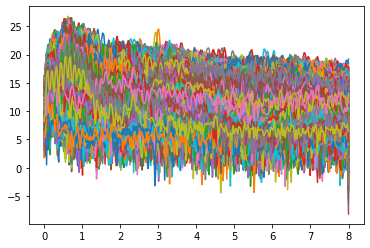

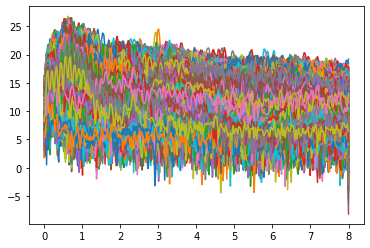

In [30]:
fd_phonems.plot()

### Se muestra un ejemplo de boxplots funcionales como análisis exploratorio

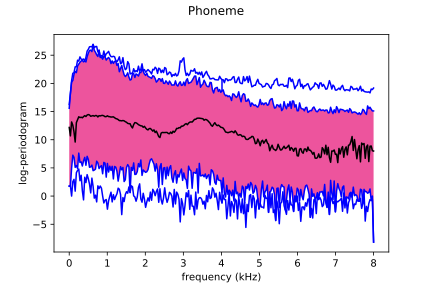

In [13]:
from skfda.exploratory.visualization import Boxplot

Boxplot(fd_phonems)

### Se realiza un conteo de la representatividad de cada fonema como ejemplo de exploración de datos

In [14]:
print(np.unique(fd_phonems_y,return_counts=True))

(array([0, 1, 2, 3, 4], dtype=int8), array([ 695, 1022,  757, 1163,  872]))


### Se realiza la transformación de los datos de audio a datos funcionales

Esto es lo que va a permitir pre-procesar cada "fonema" con el fin de:
1. Reducir la dimensionalidad de los datos
2. Mantener tanta varianza del proceso estocástico como sea posible

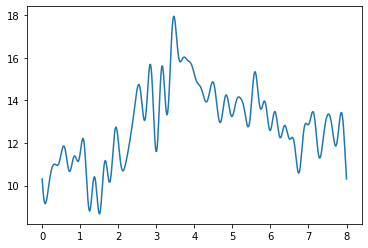

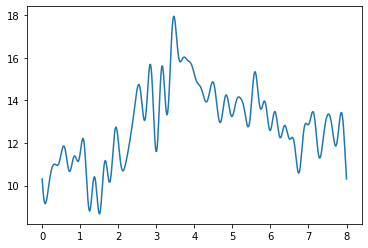

In [23]:
from skfda import FDataGrid
    
fd_phonems = FDataGrid(fd_phonems.data_matrix[:,:,0], 
                                   fd_phonems.sample_points)
basis = skfda.representation.basis.Fourier(n_basis=64)
basis_fd_phonems = fd_phonems.to_basis(basis)
basis_fd_phonems[0].plot()

### Se realiza el PCA funcional y se grafican las componentes obtenidas

[0.59316974 0.79488832 0.85604105 0.87762397 0.89266823 0.90673373
 0.91656484 0.92515814 0.93225758 0.93743549 0.94233937 0.94631387
 0.94986275 0.95318833]


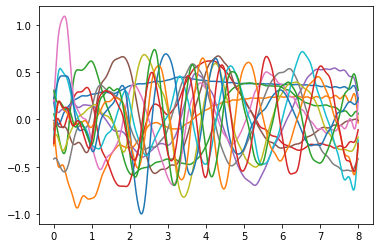

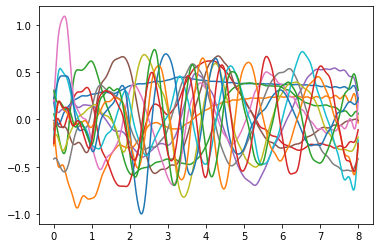

In [32]:
fpca_phonems = FPCA(n_components=14)
fpca_phonems.fit(basis_fd_phonems)
print(fpca_phonems.explained_variance_ratio_.cumsum())
fpca_phonems.components_.plot()

### Se muestra el efecto de cada componente sobre la media del proceso

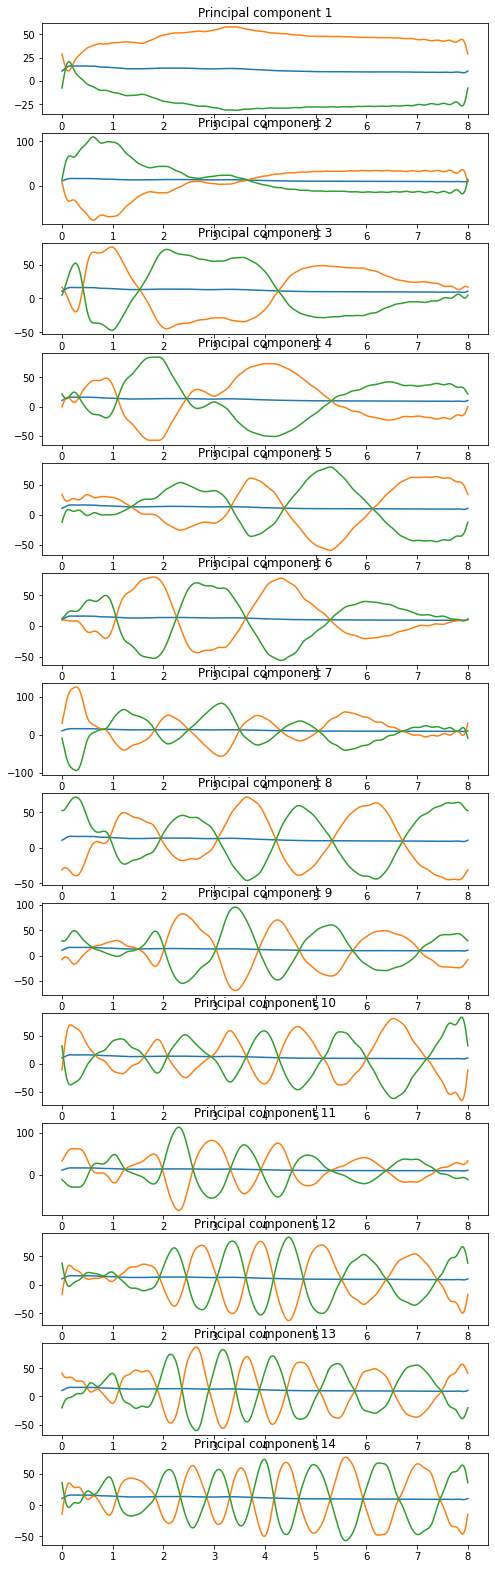

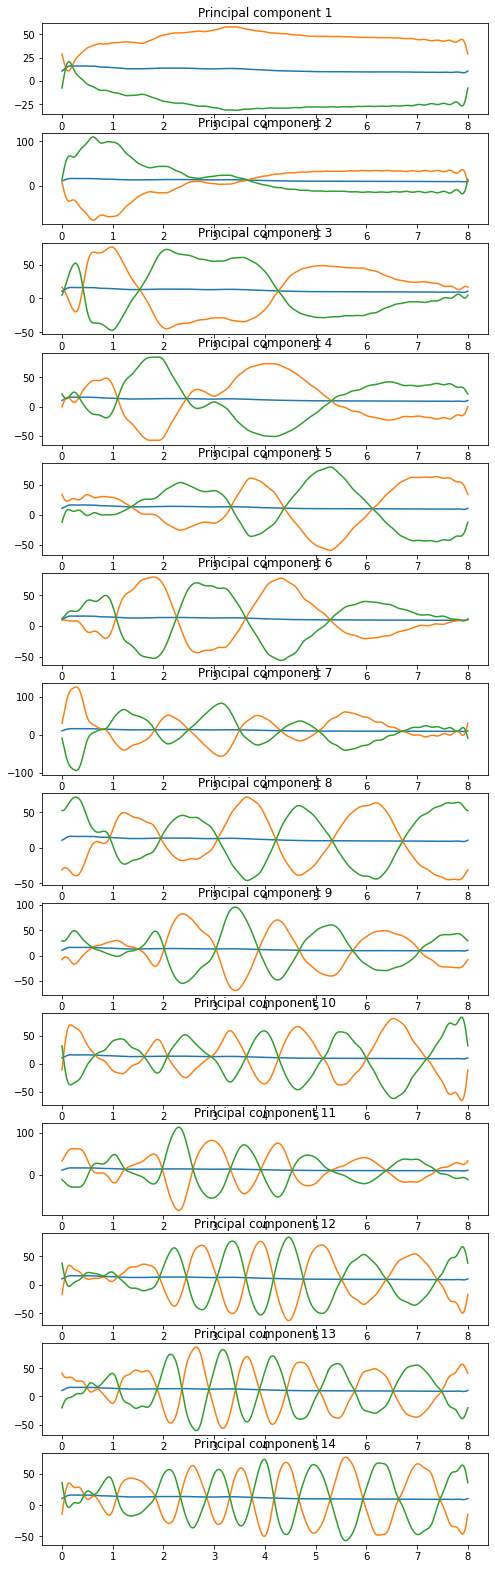

In [33]:
plot_fpca_perturbation_graphs(basis_fd_phonems.mean(),
                              fpca_phonems.components_,
                              100,
                              fig=plt.figure(figsize=(8, 7 * 4)))

### Se obtienen los scores de las componentes principales funcionales

In [34]:
fda_scores_phonems = fpca_phonems.fit_transform(basis_fd_phonems)

### Se muestra como únicamente las dos primeras componentes separan en gran medida 4 de los 5 fonemas

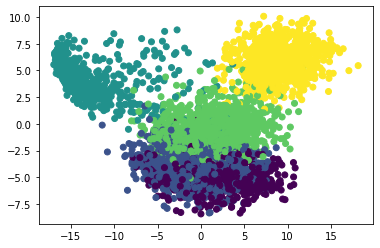

In [35]:
plt.scatter(pd.DataFrame(fda_scores_phonems)[0],pd.DataFrame(fda_scores_phonems)[1],c=fd_phonems_y)

### Seperación de datos en train y test + entrenamiento de un modelo de clasificación

In [384]:
# Inicialización de matriz para el guardado de resultados
results_phonems = np.zeros(shape=[100,2])
for i in range(100):
    
    # Partición de los datos en train y test para cada iteración
    fpca_train, fpca_test, y_fpca_train, y_fpca_test = train_test_split(pd.DataFrame(fda_scores_phonems), fd_phonems_y, test_size=0.3 ,random_state = i, stratify = fd_phonems_y)

    # Inicialización de la clase RandomForest con los hiper-parámetros previamente ajustados
    rf_fpca = RandomForestClassifier(n_estimators = 100 , bootstrap = True , max_samples=0.75,min_samples_leaf=10,
                                                                max_features = 4 , random_state = i , 
                                                                n_jobs = 30, class_weight = 'balanced_subsample')
    
    # Ajuste del RandomForest inicializado previamente al conjunto de datos de entrenamiento
    rf_fpca.fit(fpca_train,y_fpca_train)
    
    # Predicción del RandomForest entrenado en datos de entrenamiento y de test
    y_train_fpca = rf_fpca.predict(fpca_train)
    y_test_fpca = rf_fpca.predict(fpca_test)
    
    # Guardado de los resultados en la matriz inicializada previamente    
    results_phonems[i,0] = accuracy_score( y_fpca_train, y_train_fpca )
    results_phonems[i,1] = accuracy_score( y_fpca_test, y_test_fpca )

In [385]:
pd.DataFrame([fpca_train.columns[np.argsort(rf_fpca.feature_importances_)[::-1]],
              rf_fpca.feature_importances_[np.argsort(rf_fpca.feature_importances_)[::-1]],
              rf_fpca.feature_importances_[np.argsort(rf_fpca.feature_importances_)[::-1]].cumsum()]).T

,0,1,2
0,1.0,0.322262,0.322262
1,0.0,0.293570,0.615832
2,2.0,0.196934,0.812766
3,6.0,0.044802,0.857568
4,5.0,0.039715,0.897282
5,3.0,0.036591,0.933874
6,7.0,0.014221,0.948094
7,10.0,0.009458,0.957552
8,4.0,0.008858,0.966410
9,8.0,0.008568,0.974977


### Matriz de confusión en los datos de entrenamiento

In [386]:
confusion_matrix( y_fpca_train, y_train_fpca ) / confusion_matrix( y_fpca_train, y_train_fpca ).sum()

array([[0.12896071, 0.02503169, 0.        , 0.00031686, 0.        ],
       [0.02091255, 0.20532319, 0.        , 0.00031686, 0.        ],
       [0.        , 0.        , 0.16539924, 0.00253485, 0.        ],
       [0.        , 0.        , 0.00063371, 0.25697085, 0.00031686],
       [0.        , 0.        , 0.        , 0.        , 0.19328264]])

### Matriz de confusión en los datos de test

In [387]:
confusion_matrix( y_fpca_test, y_test_fpca ) / confusion_matrix( y_fpca_test, y_test_fpca ).sum()

array([[0.11382114, 0.03991131, 0.        , 0.        , 0.        ],
       [0.04656319, 0.17960089, 0.        , 0.0007391 , 0.        ],
       [0.        , 0.        , 0.16334072, 0.00443459, 0.        ],
       [0.        , 0.        , 0.0007391 , 0.25720621, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.19364375]])

### Métricas de train y test para el ejemplo

In [388]:
print('TRAIN')
print('Accuracy mean fda : ',results_phonems[:,0].mean(),'-','Accuracy std fda : ',results_phonems[:,0].std())
print('')
print('TEST')
print('Accuracy mean fda : ',results_phonems[:,1].mean(),'-','Accuracy std fda : ',results_phonems[:,1].std())

TRAIN
Accuracy mean fda :  0.9501204055766793 - Accuracy std fda :  0.00232028316441401

TEST
Accuracy mean fda :  0.9120694752402069 - Accuracy std fda :  0.006597010251321216


# Caso práctico de modelos de clasificación

## Diferenciación de niños y niñas por su crecimiento desde nacimiento hasta los 18 años

Los datos se obtienen de un estudio de crecimiento de niños(as) de Berkley de 1954.

Se capturó la estatura de 54 niñas y 39 niños desde su nacimiento hasta los 18 años. Para cada participante se tomaron 31 muestras de su estatura con un error de 3mm para cada medida. Los 31 datos se tienen para la misma edad en cada uno. El error tiende a ser mayor en edades tempranas derivado de dificultades en la medida.

Éste es un buen ejemplo de clasificación de series de tiempo. Puede tener aplicaciones en toma secuencial de mediciones con el fin de predecir resultados futuros.

Por ejemplo, si se toma la temperatura de máquinas cada minuto (u hora) durante su funcionamiento, se podría intentar predecir daños en tiempo real o en el futuro.

Si se combina esto con más datos como marca, tiempo de vida, tiempo de funcionamiento diario, sonido emitido por el motor, entre otras, se podría tener un dataset muy completo para predecir daños o tiempos de supervivencia.

## Importar librerías necesarias

###  Librerías básicas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Librerías especializadas para el problema específico

In [2]:
import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial
from skfda.datasets import fetch_cran

### Más librerías especializadas

In [5]:
from sklearn.metrics import precision_recall_curve, plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#from sksurv.ensemble import RandomSurvivalForest
#from sksurv.metrics import (concordance_index_censored,
                            #concordance_index_ipcw,
                            #cumulative_dynamic_auc)

### Se importa el conjunto de datos desde la librería scikit-fda

In [6]:
dataset = skfda.datasets.fetch_growth()

### Se realiza la división de los datos de estatura y su respectica etiqueta

In [7]:
fd = dataset['data']
y = dataset['target']
print(fd)
print(y)

Data set:    [[[ 81.3]
  [ 84.2]
  [ 86.4]
  ...
  [193.8]
  [194.3]
  [195.1]]

 [[ 76.2]
  [ 80.4]
  [ 83.2]
  ...
  [176.1]
  [177.4]
  [178.7]]

 [[ 76.8]
  [ 79.8]
  [ 82.6]
  ...
  [170.9]
  [171.2]
  [171.5]]

 ...

 [[ 68.6]
  [ 73.6]
  [ 78.6]
  ...
  [166. ]
  [166.3]
  [166.8]]

 [[ 79.9]
  [ 82.6]
  [ 84.8]
  ...
  [168.3]
  [168.4]
  [168.6]]

 [[ 76.1]
  [ 78.4]
  [ 82.3]
  ...
  [168.6]
  [168.9]
  [169.2]]]
grid_points:    (array([ 1.  ,  1.25,  1.5 ,  1.75,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,
        7.  ,  8.  ,  8.5 ,  9.  ,  9.5 , 10.  , 10.5 , 11.  , 11.5 ,
       12.  , 12.5 , 13.  , 13.5 , 14.  , 14.5 , 15.  , 15.5 , 16.  ,
       16.5 , 17.  , 17.5 , 18.  ]),)
time range:    ((1.0, 18.0),)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Se grafican las curvas como visualización

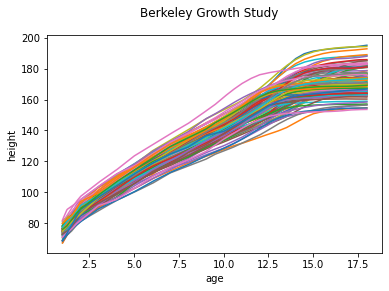

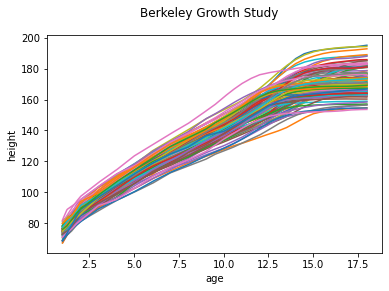

In [9]:
fd.plot()

### Se realiza un conteo de la representatividad de cada sexo como ejemplo de exploración de datos

In [10]:
print('Hombres: ',(y==0).sum())
print('Mujeres: ',(y==1).sum())

Hombres:  39
Mujeres:  54


### Se realiza la transformación de los datos de audio a datos funcionales

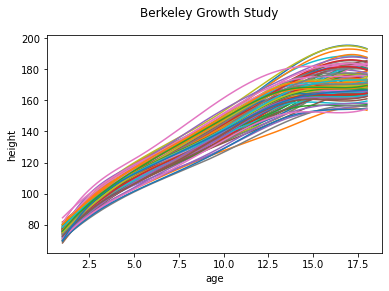

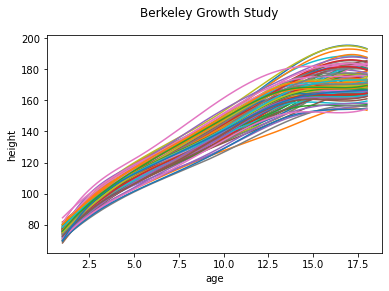

In [11]:
basis = skfda.representation.basis.BSpline(n_basis=7)
basis_fd = fd.to_basis(basis)
basis_fd.plot()

### Se realiza el PCA funcional y se grafican las componentes obtenidas

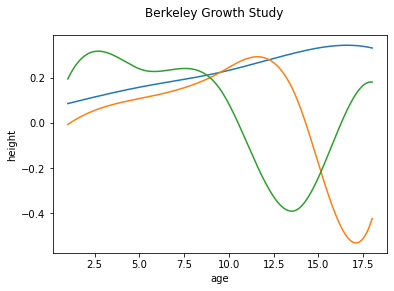

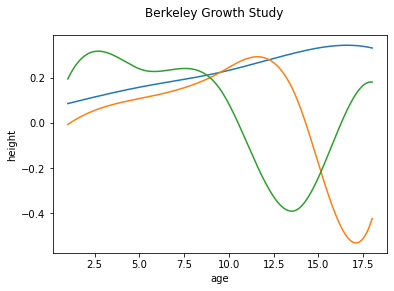

In [14]:
fpca = FPCA(n_components=3)
fpca.fit(basis_fd)
fpca.components_.plot()

### Se muestra el efecto de cada componente sobre la media del proceso

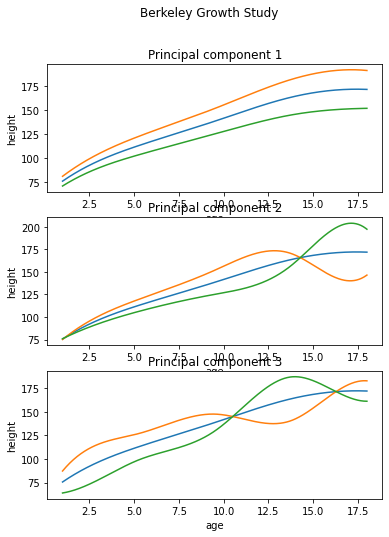

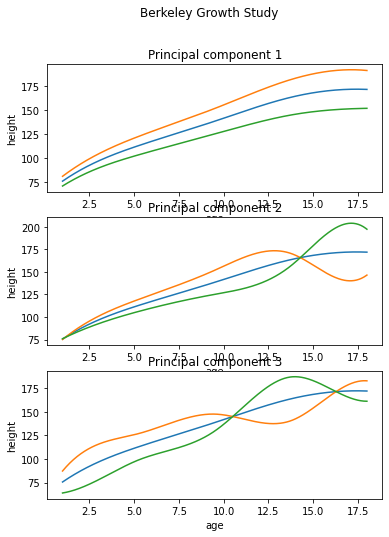

In [24]:
plot_fpca_perturbation_graphs(basis_fd.mean(),
                              fpca.components_,
                              60,
                              fig=plt.figure(figsize=(6, 2 * 4)))

### Se obtienen los scores de las componentes principales funcionales

In [16]:
fda_scores = fpca.fit_transform(basis_fd)

### Se muestra como únicamente las dos primeras componentes separan en gran medida 4 de los 5 fonemas

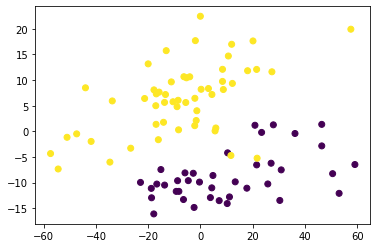

In [17]:
plt.scatter(pd.DataFrame(fda_scores)[0],pd.DataFrame(fda_scores)[1],c=y)

### Se obtienen los datos tabulares (sin suavizamiento funcional) para verificar la diferencia entre un modelo con y sin el uso de esta metodología

In [18]:
tab_data = pd.DataFrame(fd.data_matrix[:,:,0])

### Seperación de datos en train y test + entrenamiento de dos modelos de clasificación

In [19]:
results = np.zeros(shape=[100,2,3,2])
for i in range(0,100):
    tab_train, tab_test, y_tab_train, y_tab_test = train_test_split(tab_data, y, test_size=0.33 ,random_state = i , stratify = y)
    fpca_train, fpca_test, y_fpca_train, y_fpca_test = train_test_split(fda_scores, y, test_size=0.33 ,random_state = i, stratify = y)

    rf_tab = RandomForestClassifier(n_estimators = 100 , max_depth = 5,
                                                                min_samples_split = 0.05 ,
                                                                min_samples_leaf = 1 ,
                                                                max_features = 5 , bootstrap = True , 
                                                                oob_score = False , random_state = i , 
                                                                warm_start = False, class_weight = 'balanced_subsample', 
                                                                max_samples = 0.5 , n_jobs = 25, )
    rf_tab.fit(tab_train,y_tab_train)
    y_train_tab = rf_tab.predict(tab_train)
    y_test_tab = rf_tab.predict(tab_test)
    
    results[i,0,:,0] = accuracy_score( y_tab_train, y_train_tab ) , recall_score( y_tab_train, y_train_tab ) ,precision_score( y_tab_train, y_train_tab )
    results[i,0,:,1] = accuracy_score( y_tab_test, y_test_tab ) , recall_score( y_tab_test , y_test_tab ) , precision_score( y_tab_test , y_test_tab )

    rf_fpca = RandomForestClassifier(n_estimators = 100 , max_depth = 2,
                                                                min_samples_split = 0.05 ,
                                                                min_samples_leaf = 1 , max_samples=0.5,
                                                                max_features = 2 , bootstrap=True,
                                                                oob_score = False , random_state = i , 
                                                                warm_start = False , 
                                                                n_jobs = 25, class_weight = 'balanced_subsample')
    rf_fpca.fit(fpca_train,y_fpca_train)
    y_train_fpca = rf_fpca.predict(fpca_train)
    y_test_fpca = rf_fpca.predict(fpca_test)
    
    results[i,1,:,0] = accuracy_score( y_fpca_train, y_train_fpca ) , recall_score( y_fpca_train, y_train_fpca ) ,precision_score( y_fpca_train, y_train_fpca )
    results[i,1,:,1] = accuracy_score( y_fpca_test, y_test_fpca ) , recall_score( y_fpca_test, y_test_fpca  ) , precision_score( y_fpca_test , y_test_fpca )

### Métricas de train y test para el ejemplo tabular

In [20]:
print('TRAIN')
print('Accuracy mean tabular : ',results[:,0,0,0].mean(),'-','Accuracy std tabular : ',results[:,0,0,0].std())
print('Recall mean tabular : ',results[:,0,1,0].mean(),'-','Recall std tabular : ',results[:,0,1,0].std())
print('Precision mean tabular : ',results[:,0,2,0].mean(),'-','Precision std tabular : ',results[:,0,2,0].std())
print('')
print('TEST')
print('Accuracy mean tabular : ',results[:,0,0,1].mean(),'-','Accuracy std tabular : ',results[:,0,0,1].std())
print('Recall mean tabular : ',results[:,0,1,1].mean(),'-','Recall std tabular : ',results[:,0,1,1].std())
print('Precision mean tabular : ',results[:,0,2,1].mean(),'-','Precision std tabular : ',results[:,0,2,1].std())

TRAIN
Accuracy mean tabular :  0.9588709677419355 - Accuracy std tabular :  0.016819881947269542
Recall mean tabular :  0.9469444444444447 - Recall std tabular :  0.02327207567392389
Precision mean tabular :  0.9817353652353654 - Precision std tabular :  0.014765416439306475

TEST
Accuracy mean tabular :  0.8938709677419355 - Accuracy std tabular :  0.06276577207045586
Recall mean tabular :  0.8822222222222222 - Recall std tabular :  0.07906865277625419
Precision mean tabular :  0.9334911850705194 - Precision std tabular :  0.05735032159079345


### Métricas de train y test para el ejemplo FDA

In [21]:
print('TRAIN')
print('Accuracy mean fda : ',results[:,1,0,0].mean(),'-','Accuracy std fda : ',results[:,1,0,0].std())
print('Recall mean fda : ',results[:,1,1,0].mean(),'-','Recall std fda : ',results[:,1,1,0].std())
print('Precision mean fda : ',results[:,1,2,0].mean(),'-','Precision std fda : ',results[:,1,2,0].std())
print('')
print('TEST')
print('Accuracy mean fda : ',results[:,1,0,1].mean(),'-','Accuracy std fda : ',results[:,1,0,1].std())
print('Recall mean fda : ',results[:,1,1,1].mean(),'-','Recall std fda : ',results[:,1,1,1].std())
print('Precision mean fda : ',results[:,1,2,1].mean(),'-','Precision std fda : ',results[:,1,2,1].std())

TRAIN
Accuracy mean fda :  0.9714516129032259 - Accuracy std fda :  0.017793912134577646
Recall mean fda :  0.9763888888888889 - Recall std fda :  0.018992769904412985
Precision mean fda :  0.9749557494077618 - Precision std fda :  0.02193933305596497

TEST
Accuracy mean fda :  0.9122580645161291 - Accuracy std fda :  0.04471670568042182
Recall mean fda :  0.9266666666666667 - Recall std fda :  0.060797173423575344
Precision mean fda :  0.9273818088292108 - Precision std fda :  0.05824061777605669


# Ejercicio práctico de predicción - Modelo de supervivencia

### Este tipo de modelos se utilizan para predecir la función de supervivencia (función de probabilidad de tiempo a un evento en particular) para diferentes individuos en una población

Datos de cáncer de pulmón en un estudio de análisis de supervivencia

## Cargar datos para el entrenamiento del modelo

In [53]:
rotterdam_data = fetch_cran('rotterdam', 'survival')

/home/gabriel/anaconda3/lib/python3.8/site-packages/rdata/conversion/_conversion.py:546: UserWarning: Missing constructor for R class "haven_labelled". The constructor for class "vctrs_vctr" will be used instead.
  warnings.warn(missing_msg + solution_msg,
/home/gabriel/anaconda3/lib/python3.8/site-packages/rdata/conversion/_conversion.py:546: UserWarning: Missing constructor for R class "vctrs_vctr". The constructor for class "double" will be used instead.
  warnings.warn(missing_msg + solution_msg,
/home/gabriel/anaconda3/lib/python3.8/site-packages/rdata/conversion/_conversion.py:546: UserWarning: Missing constructor for R class "double". The underlying R object is returned instead.
  warnings.warn(missing_msg + solution_msg,


#### Imprimir el tipo de datos descargado + "Visualizar" los datos

In [54]:
print(type(rotterdam_data))
rotterdam_data

<class 'dict'>


{'rotterdam':          pid    year   age  meno   size  grade  nodes    pgr     er  hormon  \
 0        1.0  1992.0  74.0   1.0   <=20    3.0    0.0   35.0  291.0     0.0   
 1        2.0  1984.0  79.0   1.0  20-50    3.0    0.0   36.0  611.0     0.0   
 2        3.0  1983.0  44.0   0.0   <=20    2.0    0.0  138.0    0.0     0.0   
 3        4.0  1985.0  70.0   1.0  20-50    3.0    0.0    0.0   12.0     0.0   
 4        5.0  1983.0  75.0   1.0   <=20    3.0    0.0  260.0  409.0     0.0   
 ...      ...     ...   ...   ...    ...    ...    ...    ...    ...     ...   
 2977  3003.0  1990.0  73.0   1.0  20-50    3.0    1.0  167.0  142.0     0.0   
 2978  3004.0  1987.0  75.0   1.0    >50    3.0   11.0    5.0   20.0     1.0   
 2979  3005.0  1985.0  79.0   1.0  20-50    3.0    6.0  189.0   21.0     0.0   
 2980  3006.0  1983.0  71.0   1.0   <=20    3.0    0.0    0.0   55.0     0.0   
 2981  3007.0  1993.0  68.0   1.0   <=20    3.0   12.0    0.0    0.0     1.0   
 
       chemo        rtime

### Acceder a los datos en el diccionario

In [55]:
rotterdam_data['rotterdam']

,pid,year,age,meno,size,grade,nodes,pgr,er,hormon,chemo,rtime,recur,dtime,death
0,1.0,1992.0,74.0,1.0,<=20,3.0,0.0,35.0,291.0,0.0,0.0,1798.999948,0.0,1798.999948,0.0
1,2.0,1984.0,79.0,1.0,20-50,3.0,0.0,36.0,611.0,0.0,0.0,2828.000021,0.0,2828.000021,0.0
2,3.0,1983.0,44.0,0.0,<=20,2.0,0.0,138.0,0.0,0.0,0.0,6011.999804,0.0,6011.999804,0.0
3,4.0,1985.0,70.0,1.0,20-50,3.0,0.0,0.0,12.0,0.0,0.0,2623.999895,0.0,2623.999895,0.0
4,5.0,1983.0,75.0,1.0,<=20,3.0,0.0,260.0,409.0,0.0,0.0,4914.999997,0.0,4914.999997,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977,3003.0,1990.0,73.0,1.0,20-50,3.0,1.0,167.0,142.0,0.0,0.0,1989.999951,0.0,1989.999951,1.0
2978,3004.0,1987.0,75.0,1.0,>50,3.0,11.0,5.0,20.0,1.0,0.0,45.000001,0.0,45.000001,1.0
2979,3005.0,1985.0,79.0,1.0,20-50,3.0,6.0,189.0,21.0,0.0,0.0,581.999975,0.0,581.999975,1.0
2980,3006.0,1983.0,71.0,1.0,<=20,3.0,0.0,0.0,55.0,0.0,0.0,4972.000179,0.0,4972.000179,1.0


### Ver los tipos de datos en cada columna

In [56]:
rotterdam_data['rotterdam'].dtypes

pid        float64
year       float64
age        float64
meno       float64
size      category
grade      float64
nodes      float64
pgr        float64
er         float64
hormon     float64
chemo      float64
rtime      float64
recur      float64
dtime      float64
death      float64
dtype: object

### Pre-procesar la columna categórica 

In [57]:
# Importar módulo de la librería
from sklearn.preprocessing import OneHotEncoder


# Inicializar clase
enc = OneHotEncoder()

# Realizar el fit del encoder
enc.fit(rotterdam_data['rotterdam'].iloc[:,1:13][['size']])

# Crear las columnas en el dataframe
rotterdam_data['rotterdam'][enc.categories_[0][0]] = enc.transform(rotterdam_data['rotterdam'].iloc[:,1:13][['size']]).toarray()[:,0]
rotterdam_data['rotterdam'][enc.categories_[0][1]] = enc.transform(rotterdam_data['rotterdam'].iloc[:,1:13][['size']]).toarray()[:,1]
rotterdam_data['rotterdam'][enc.categories_[0][2]] = enc.transform(rotterdam_data['rotterdam'].iloc[:,1:13][['size']]).toarray()[:,2]

# Eliminar la columna categórica original
rotterdam_data['rotterdam'].drop(columns='size',inplace=True)

### Preparaciones adicionales de los datos

In [59]:
# Transformar datos de censura a datos categóricos
y_data=rotterdam_data['rotterdam'].iloc[:,12:14][['death','dtime']]

y_data['death'] = np.where(y_data['death']==1,False,True)

#Poner los datos de test en el formato correcto de la librería
y_data = y_data.to_records(index=False)


rec.array([( True, 1798.99994755), ( True, 2828.00002146),
           ( True, 6011.99980354), ..., (False,  581.99997461),
           (False, 4972.00017929), (False,  378.99998945)],
          dtype=[('death', '?'), ('dtime', '<f8')])

In [64]:
rotterdam_data['rotterdam'].iloc[:,np.r_[1:12,14:17]].iloc[:,0:1].to_csv('independent_survival_variables_example.csv')
rotterdam_data['rotterdam'].iloc[:,12:14][['death','dtime']]['death'] = np.where(rotterdam_data['rotterdam'].iloc[:,12:14][['death','dtime']]['death']==1,False,True)
rotterdam_data['rotterdam'].iloc[:,12:14][['death','dtime']].to_csv('y_survival_variables.csv')
rotterdam_data['rotterdam'].iloc[:,np.r_[1:12,14:17]].to_csv('independent_survival_variables.csv')

In [156]:
# Dividir datos en train y test
train, test, y_train, y_test = train_test_split(rotterdam_data['rotterdam'].iloc[:,np.r_[1:12,14:17]], rotterdam_data['rotterdam'].iloc[:,12:14][['death','dtime']], test_size=0.33 ,random_state = 123 )

# Transformar datos de censura a datos categóricos
y_train['death'] = np.where(y_train['death']==1,False,True)
y_test['death'] = np.where(y_test['death']==1,False,True)

#Poner los datos de test en el formato correcto de la librería
y_train = y_train.to_records(index=False)
y_test = y_test.to_records(index=False)

### Entrenamiento del modelo

In [157]:
# Inicialización de la clase
rf_surv = RandomSurvivalForest(n_estimators=100,
                           max_depth = None,
                           min_samples_split = 0.01,
                           min_samples_leaf = 0.01,
                           max_features = 8,
                           n_jobs=20,
                           random_state=123, max_samples=0.9,bootstrap = True)

# Fit del modelo
rf_surv.fit(train,y_train)

# Predicciones sobre train y test
y_train_pred = rf_surv.predict(train)
y_test_pred = rf_surv.predict(test)

In [158]:
print('Performance del modelo en train : ',rf_surv.score(train, y_train))
print('Performance del modelo en test : ',rf_surv.score(test, y_test))

Performance del modelo en train :  0.8974168965584708
Performance del modelo en test :  0.8807094674790314


### Ejemplos de los resultados

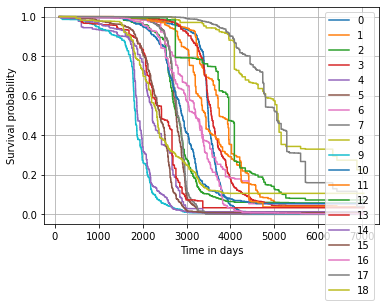

In [370]:
surv = rf_surv.predict_survival_function(test.iloc[21:40], return_array=True)

for i, s in enumerate(surv):
    plt.step(rf_surv.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)